In [ ]:
import os
import sys
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import polars as pl
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib.lines import Line2D

from datetime import datetime, timezone

PROJECT_PATH = os.path.abspath(os.path.join("..", ".."))
PIPELINE_PATH = os.path.join(PROJECT_PATH, "pipeline")
DATA_DIRECTORY = os.path.join(PROJECT_PATH, "data")

if PIPELINE_PATH not in sys.path:
    sys.path.append(PIPELINE_PATH)
    
from utils.paths import DESPIKED_DATA_DIRECTORY
from utils.import_data import import_acropolis_site_data
from config.sites_deloyment_times import deployment_times

assert(os.path.exists(DATA_DIRECTORY))
assert(os.path.exists(DESPIKED_DATA_DIRECTORY))

In [38]:
sites = [
            "TUMR", "TUMRv2", "FELR", "TAUR", "DLRR", "SENR", "RDIR", "SCHR", "FINR",
            "SWMR", "MAIR", "PASR", "GROR", "BLUT_48", "BLUT_85", "NPLR", 
            "BOGR", "HARR", "BALR"
        ]

In [39]:
# Load ACROPOLIS Data
all_systems = []

for site in sites:
    df_system = import_acropolis_site_data(target_directory=DESPIKED_DATA_DIRECTORY,
                                    deployment_times=deployment_times,
                                    site_name=site)
        
    all_systems.append(df_system)
    
del df_system
df = pl.concat(all_systems, how="diagonal")
df.head(1).vstack(df.tail(1))

datetime,system_id,system_name,gmp343_corrected,gmp343_edge_corrected,gmp343_temperature,sht45_humidity,h2o_v%,bme280_pressure,enclosure_bme280_pressure,wxt532_speed_avg,wxt532_direction_avg,gmp343_dry,slope,intercept,gmp343_edge_dry,cal_gmp343_slope,cal_gmp343_intercept,Flag
"datetime[μs, UTC]",i32,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
2024-02-14 00:00:00 UTC,4,"""tum-esm-midcost-raspi-4""",444.76,null,28.35,21.023333,0.857268,946.815,959.11,null,null,476.972266,0.989056,-26.548261,null,null,null,"""U"""
2025-06-20 10:10:00 UTC,19,"""acropolis-19""",422.81,422.2,34.0,31.14685,1.763796,940.355,961.04,0.9,171.9,435.430097,0.991564,-8.948908,435.45,null,null,"""U"""


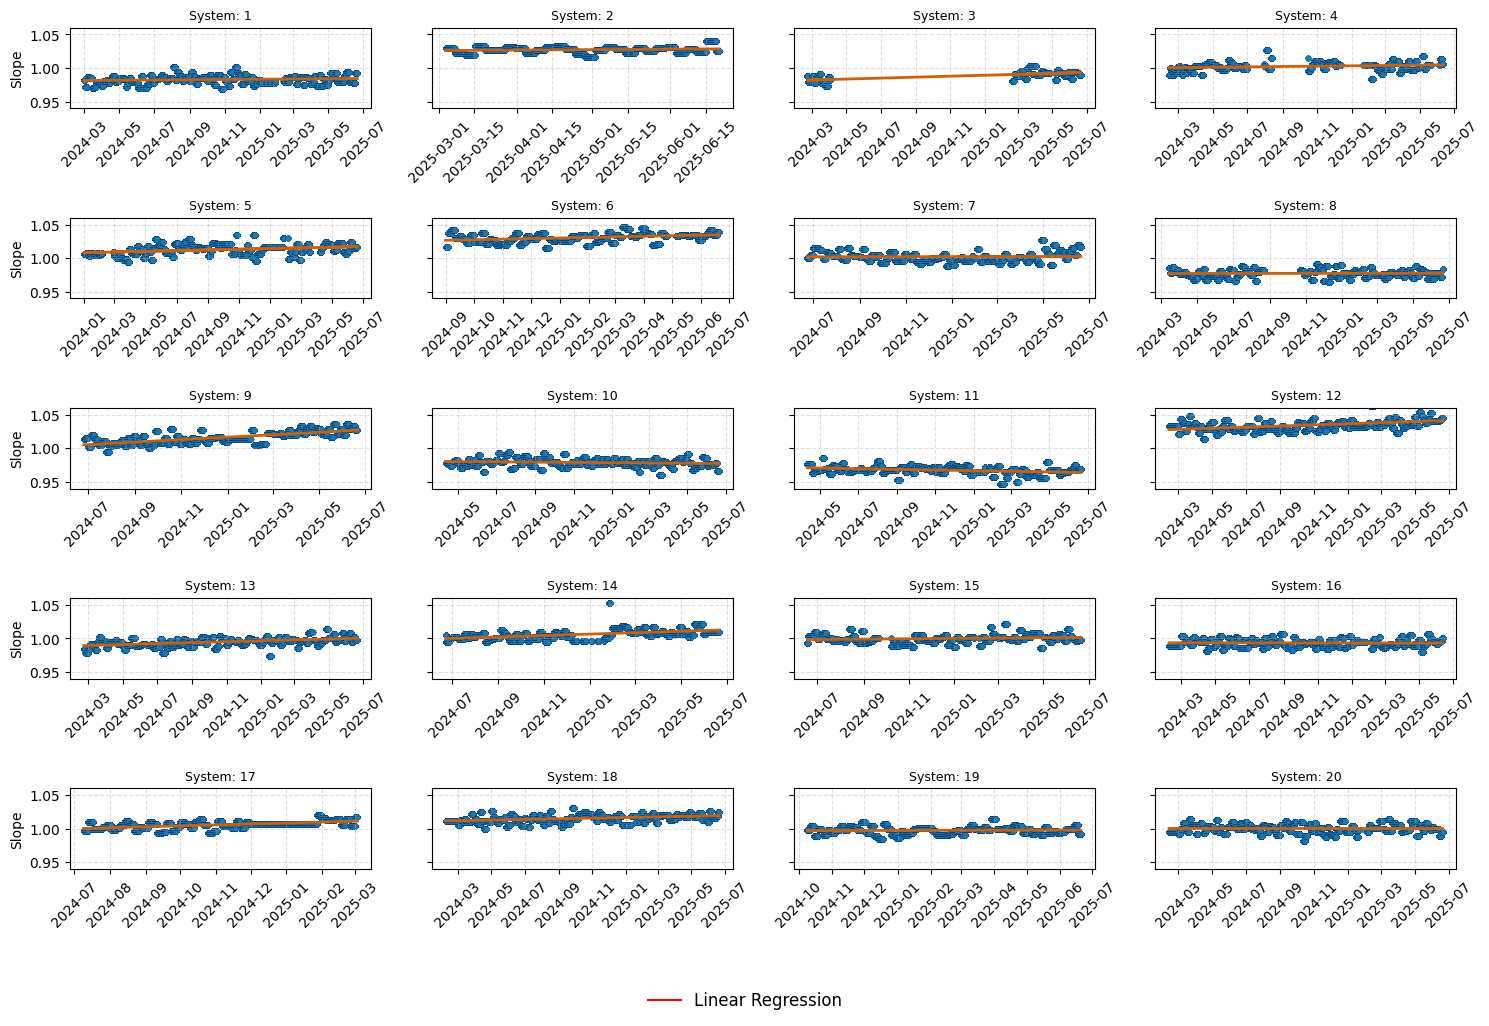

In [40]:
def plot_slope_trends_per_system(
    df: pl.DataFrame,
    y_col_name: str = "slope",
    y_title: str = "Slope",
    y_lim: tuple[float, float] = (0.95, 1.06),
    n_cols: int = 4,
    figsize: tuple[int, int] = (15, 10),
    dpi: int = 100,
):
    # unique system IDs
    system_ids = (
        df.select("system_id")
          .unique()
          .sort("system_id")
          .to_series()
          .to_list()
    )

    n_systems = len(system_ids)
    n_rows = int(np.ceil(n_systems / n_cols))

    # setup subplots
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=figsize, dpi=dpi,
                             sharex=False, sharey=True)
    axes = np.array(axes).reshape(n_rows, n_cols)

    for idx, system_id in enumerate(system_ids):
        row, col = divmod(idx, n_cols)
        ax = axes[row, col]
        
        if system_id == 6:
            df_sys = df.filter(pl.col("system_id") == system_id).filter(pl.col("datetime") > datetime(2024, 9, 1).replace(tzinfo=timezone.utc))
        else:
            # Filter and extract
            df_sys = df.filter(pl.col("system_id") == system_id)
        x = df_sys.get_column("datetime").to_numpy()
        y = df_sys.get_column(y_col_name).to_numpy()

        # Scatter
        ax.scatter(x, y, s=15, alpha=0.6, edgecolor='black', linewidth=0.01)

        # Regression (if enough points)
        if len(x) > 1:
            x_num = mdates.date2num(x).reshape(-1, 1)
            model = LinearRegression()
            model.fit(x_num, y)
            y_pred = model.predict(x_num)
            ax.plot(x, y_pred, color="#D55E00", linewidth=2)

        # Baseline
        #ax.axhline(1.0, linestyle='--', color='black', linewidth=1)

        # Titles & labels
        ax.set_title(f"System: {system_id}", fontsize=9)
        ax.set_ylim(y_lim)
        #ax.set_xlabel("Date", fontsize=8)
        ax.tick_params(axis='x', labelrotation=45)
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
        ax.grid(True, linestyle='--', alpha=0.4)
        if col == 0:
            ax.set_ylabel(y_title)

    # Turn off unused axes
    for idx in range(n_systems, n_rows * n_cols):
        axes.flat[idx].axis("off")

    # Shared legend
    line_reg  = Line2D([0], [0], color="red", label="Linear Regression")
    #line_base = Line2D([0], [0], linestyle="--", color="black", label="Baseline")
    fig.legend(
        handles=[line_reg],
        loc='lower center',
        bbox_to_anchor=(0.5, -0.03),
        ncol=2,
        frameon=False,
        fontsize=12,
    )

    #fig.suptitle("Slope Trends per System (Raw Values + Linear Fit)", fontsize=14, y=1.02)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()
    
    
plot_slope_trends_per_system(
    df=df,
    y_col_name="slope",
    y_title="Slope",
    y_lim=(0.94, 1.06),
    figsize=(15, 10)
)